# Import Libraries

In [2]:
!pip install tensorflow --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 102.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.2 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.20.0 which is incompatible.


In [3]:
import warnings, os, tensorflow as tf
import logging
import absl.logging
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_DISABLE_MODEL_PRUNING'] = '1'
absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

try:
    if not hasattr(tf.keras.backend, "_gradient_registry"):
        tf.keras.backend._gradient_registry = {}
    elif tf.keras.backend._gradient_registry is None:
        tf.keras.backend._gradient_registry = {}
except:
    pass

try:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except:
    pass

try:
    from tensorflow.python.util import deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False
except:
    pass

In [8]:
import os
import numpy as np
import shutil
import hashlib
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau ,Callback
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import label_binarize
from tensorflow.keras.optimizers import Adam
import itertools
import seaborn as sns
import time

# Dataset Cleaning 

In [6]:
ORIGINAL_DIR = "/kaggle/input/plantvillage dataset/color"
CLEAN_DIR = "/kaggle/working/plantvillage_clean"

if os.path.exists(CLEAN_DIR):
    shutil.rmtree(CLEAN_DIR)

print("Copying dataset and removing exact duplicates...\n")

hash_dict = {}           
duplicates_removed = 0
copied_images = 0

for root, dirs, files in os.walk(ORIGINAL_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            src_path = os.path.join(root, file)
            
            with open(src_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            
            rel_path = os.path.relpath(src_path, ORIGINAL_DIR)
            dst_path = os.path.join(CLEAN_DIR, rel_path)
            dst_folder = os.path.dirname(dst_path)
            
            if file_hash not in hash_dict:
                os.makedirs(dst_folder, exist_ok=True)
                shutil.copy2(src_path, dst_path)
                hash_dict[file_hash] = dst_path
                copied_images += 1
            else:
                duplicates_removed += 1

print("Dataset cleaning completed!")
print(f"Unique images copied      : {copied_images:,}")
print(f"Exact duplicates skipped  : {duplicates_removed:,}")
print(f"Clean dataset path        : {CLEAN_DIR}")

SOURCE_DIR = CLEAN_DIR

Copying dataset and removing exact duplicates...

Dataset cleaning completed!
Unique images copied      : 54,284
Exact duplicates skipped  : 21
Clean dataset path        : /kaggle/working/plantvillage_clean


# Dataset Exploration & Visualization

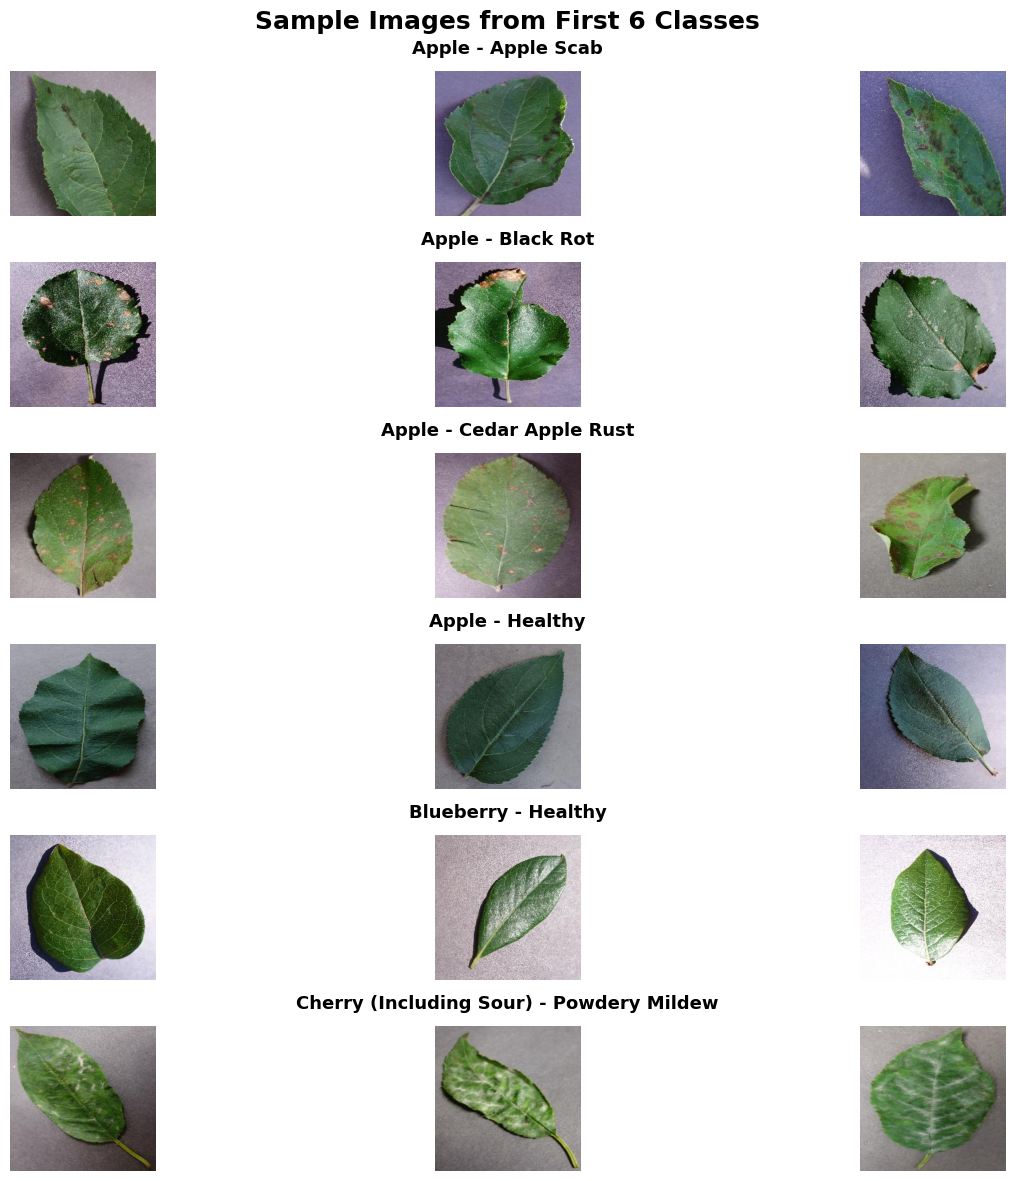

In [16]:
SOURCE_DIR = "/kaggle/working/plantvillage_clean"

classes = sorted([d for d in os.listdir(SOURCE_DIR) 
                  if os.path.isdir(os.path.join(SOURCE_DIR, d))])[:6]

plt.figure(figsize=(15, 12))
plt.suptitle("Sample Images from First 6 Classes", 
             fontsize=18, fontweight='bold', y=0.98)

plot_num = 1
for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)
    images = [f for f in os.listdir(cls_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    samples = random.sample(images, min(3, len(images)))
    
    plant = cls.split("___")[0].replace("_", " ").title()
    disease = "Healthy" if len(cls.split("___")) == 1 else cls.split("___")[1].replace("_", " ").title()
    title = f"{plant} - {disease}"
    
    for img_file in samples:
        img_path = os.path.join(cls_path, img_file)
        img = plt.imread(img_path)
        
        plt.subplot(6, 3, plot_num)
        plt.imshow(img)
        if plot_num % 3 == 2: 
            plt.title(title, fontsize=13, fontweight='bold', pad=12)
        plt.axis('off')
        plot_num += 1

plt.tight_layout()
plt.show()

# Config & Data Splitting

In [12]:
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30
FINE_TUNE_EPOCH=10
VALIDATION_SPLIT=0.15
TEST_SPLIT= 0.15

In [13]:
# Paths
SOURCE_DIR = "/kaggle/working/plantvillage_clean"   
WORK_DIR   = "/kaggle/working/plantvillage_split"

train_dir = os.path.join(WORK_DIR, "train")
val_dir   = os.path.join(WORK_DIR, "val")
test_dir  = os.path.join(WORK_DIR, "test")

# Clean previous split (fresh start)
for folder in [train_dir, val_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir,   exist_ok=True)
os.makedirs(test_dir,  exist_ok=True)

print("Splitting dataset... (70% train | 15% val | 15% test)")

classes = sorted([c for c in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, c))])

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)
    images = [os.path.join(cls_path, img) for img in os.listdir(cls_path)
              if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # First: separate test set (15%)
    train_val_imgs, test_imgs = train_test_split(
        images, test_size=TEST_SPLIT, random_state=42, shuffle=True)
    
    # Then: from remaining 85%, take 15% of total remaining for validation
    train_imgs, val_imgs = train_test_split(
        train_val_imgs,
        test_size=VALIDATION_SPLIT / (1 - TEST_SPLIT),  
        random_state=42,
        shuffle=True
    )
    
    # Create class folders and copy images
    for split_dir, split_imgs in zip([train_dir, val_dir, test_dir],
                                     [train_imgs, val_imgs, test_imgs]):
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)
        for src_path in split_imgs:
            shutil.copy(src_path, os.path.join(split_dir, cls))

print("Dataset split completed successfully!")
print(f"Train → {train_dir}")
print(f"Val   → {val_dir}")
print(f"Test  → {test_dir}")

Splitting dataset... (70% train | 15% val | 15% test)
Dataset split completed successfully!
Train → /kaggle/working/plantvillage_split/train
Val   → /kaggle/working/plantvillage_split/val
Test  → /kaggle/working/plantvillage_split/test


In [14]:
# Check the new split folders 
print("Split completed successfully!")

print(f"\nTrain directory: {train_dir}")
print(f"Number of classes in train:", len(os.listdir(train_dir)))
print(f"Total train images: {sum(len(os.listdir(os.path.join(train_dir, c))) for c in os.listdir(train_dir))}")

print(f"\nValidation directory: {val_dir}")
print(f"Number of classes in val:  {len(os.listdir(val_dir))}")
print(f"Total val images:   {sum(len(os.listdir(os.path.join(val_dir, c))) for c in os.listdir(val_dir))}")

print(f"\nTest directory: {test_dir}")
print(f"Number of classes in test: {len(os.listdir(test_dir))}")
print(f"Total test images:  {sum(len(os.listdir(os.path.join(test_dir, c))) for c in os.listdir(test_dir))}")

Split completed successfully!

Train directory: /kaggle/working/plantvillage_split/train
Number of classes in train: 38
Total train images: 37971

Validation directory: /kaggle/working/plantvillage_split/val
Number of classes in val:  38
Total val images:   8154

Test directory: /kaggle/working/plantvillage_split/test
Number of classes in test: 38
Total test images:  8159


# Data Generators

In [7]:
TRAIN_DIR = "/kaggle/working/plantvillage_split/train"
VAL_DIR   = "/kaggle/working/plantvillage_split/val"
TEST_DIR  = "/kaggle/working/plantvillage_split/test"

In [8]:
# Train datagen with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,    # NORMALIZED PIXEL VALUES TO [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
)    
    

In [9]:
# Validation & Test (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
#train data loader
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True   

)

Found 37985 images belonging to 38 classes.


In [11]:
for images, labels in train_generator:
    print(images.shape, labels.shape)
    break

(16, 224, 224, 3) (16, 38)


In [12]:
#validation data loader
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8158 images belonging to 38 classes.


In [13]:
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8162 images belonging to 38 classes.


In [14]:
class_names=list(train_generator.class_indices.keys())
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

## VGG-19 Architecture Explanation
**VGG-19 is a CNN with 19 layers (16 conv + 3 dense). Steps: Input (224x224x3) → Conv blocks (with 3x3 filters) → MaxPooling → FC layers.**

**Graph:** 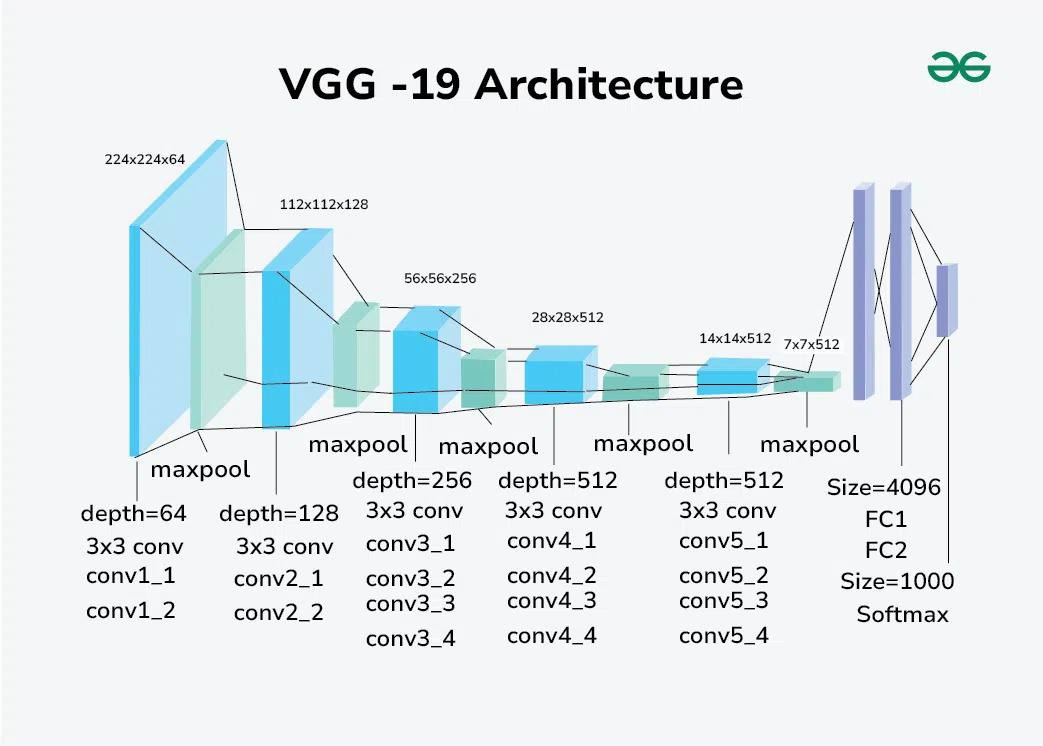

**Reference:** Simonyan & Zisserman (2014) - https://arxiv.org/abs/1409.1556

# Build VGG-19 From Scratch

In [15]:
model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 4
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 5
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.summary()


I0000 00:00:1764297886.092740      47 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,31

 Total params: 139,725,926 (533.01 MB)

 Trainable params: 139,725,926 (533.01 MB)

 Non-trainable params: 0 (0.00 B)

# Compile & Train VGG19

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),   
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    "/kaggle/working/vgg19_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


callbacks = [checkpoint, early_stop, reduce_lr]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,  
    verbose=1, 
    callbacks=callbacks
)

Epoch 1/30
   1/2375 ━━━━━━━━━━━━━━━━━━━━ 13:19:20 20s/step - accuracy: 0.0000e+00 - loss: 3.6375

I0000 00:00:1764297907.779712     150 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2375/2375 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.1754 - loss: 3.0935
Epoch 1: val_accuracy improved from None to 0.33795, saving model to /kaggle/working/vgg19_best.keras
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 504s 204ms/step - accuracy: 0.2302 - loss: 2.8537 - val_accuracy: 0.3380 - val_loss: 2.3879 - learning_rate: 1.0000e-04
Epoch 2/30
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3932 - loss: 2.0963
Epoch 2: val_accuracy improved from 0.33795 to 0.63717, saving model to /kaggle/working/vgg19_best.keras
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 475s 200ms/step - accuracy: 0.4655 - loss: 1.8191 - val_accuracy: 0.6372 - val_loss: 1.1596 - learning_rate: 1.0000e-04
Epoch 3/30
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6322 - loss: 1.1847
Epoch 3: val_accuracy improved from 0.63717 to 0.77078, saving model to /kaggle/working/vgg19_best.keras
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 467s 196ms/step - accuracy: 0.6682 - loss: 1.0635 - val_accuracy: 0.7708 - val_loss: 0.7131 - le

In [17]:
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
final_val_acc = history.history['val_accuracy'][-1]
final_train_acc = history.history['accuracy'][-1]

print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Best model saved as: /kaggle/working/vgg19_best.keras")

Best validation accuracy: 0.9874 at epoch 27
Final validation accuracy: 0.9783
Final training accuracy: 0.9909
Best model saved as: /kaggle/working/vgg19_best.h5


In [18]:
test_generator.reset()   

test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE + 1,
    verbose=1
)

print(f"\nFinal Test Accuracy  = {test_accuracy*100:.3f}%")
print(f"Final Test Loss       = {test_loss:.4f}")

511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - accuracy: 0.9762 - loss: 0.0812

Final Test Accuracy  = 97.623%
Final Test Loss       = 0.0812


In [19]:
y_pred = model.predict(test_generator, 
                       steps = test_generator.samples // test_generator.batch_size + 1,
                       verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

511/511 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step


# Loss & Accuracy

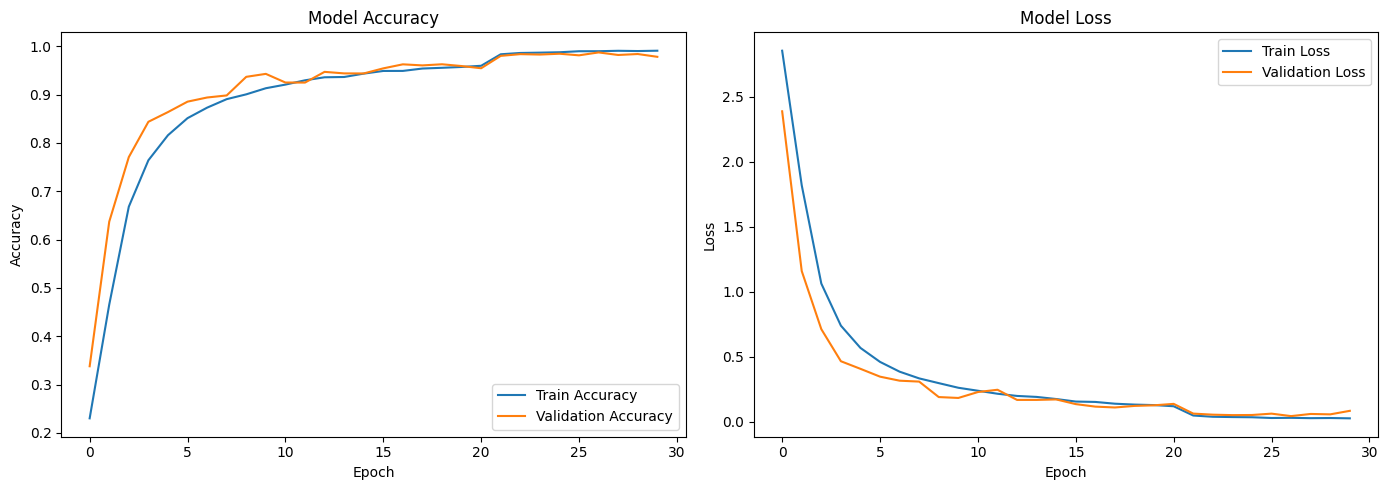

In [20]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation Matrix

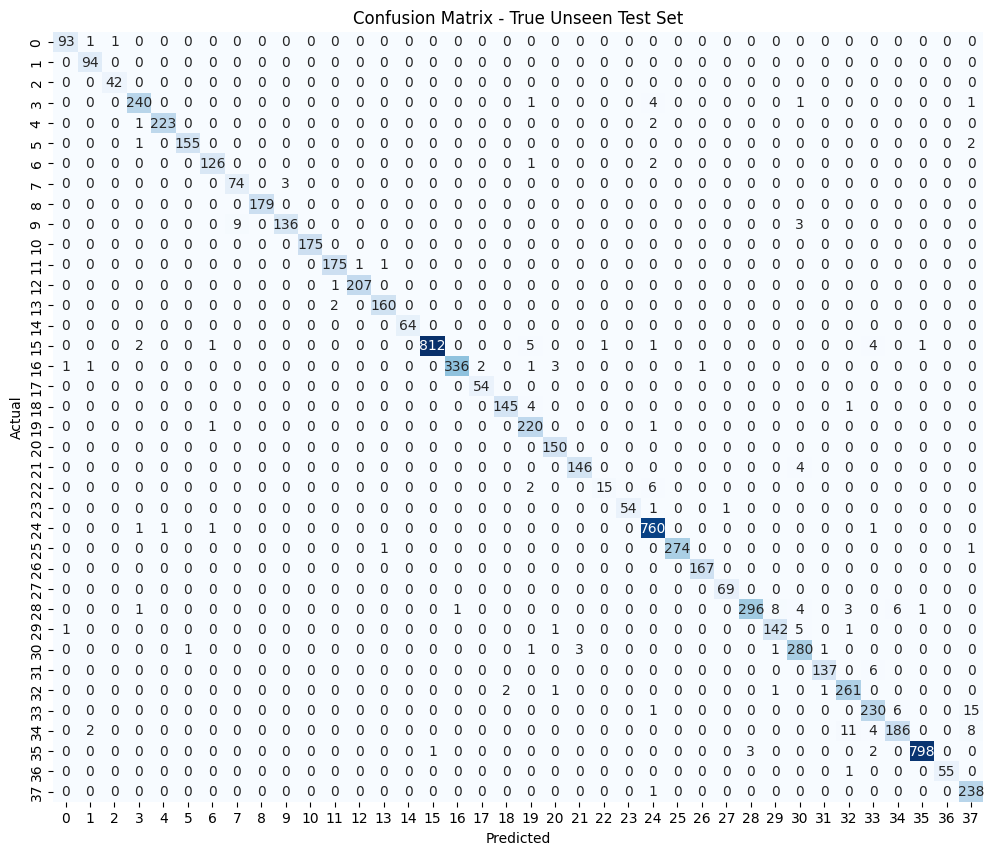

In [21]:
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - True Unseen Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report (Precision, Recall, F1-score)

In [22]:
# 5. Classification Report
print("Classification Report on True Test Set:\n")
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report on True Test Set:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98        95
                                 Apple___Black_rot       0.96      1.00      0.98        94
                          Apple___Cedar_apple_rust       0.98      1.00      0.99        42
                                   Apple___healthy       0.98      0.97      0.97       247
                               Blueberry___healthy       1.00      0.99      0.99       226
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.99       158
                 Cherry_(including_sour)___healthy       0.98      0.98      0.98       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.96      0.92        77
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       179
               Corn_(maize)___Northern

# ROC & AUC

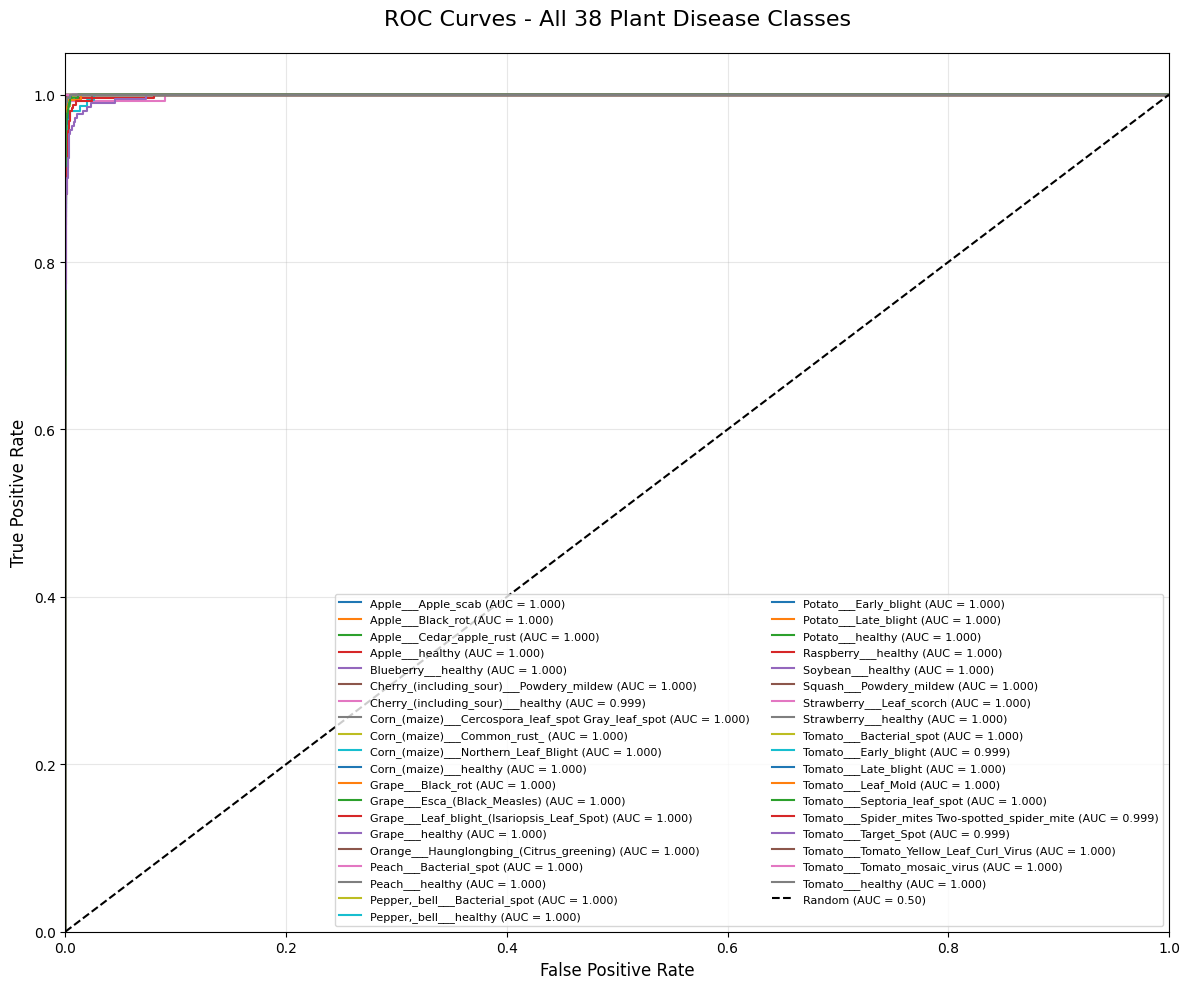

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

plt.figure(figsize=(12, 10))

y_true_bin = label_binarize(y_true, classes=np.arange(test_generator.num_classes))

if y_true_bin.ndim == 1:
    y_true_bin = y_true_bin.reshape(-1, 1)

for i in range(test_generator.num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.3f})') 

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All 38 Plant Disease Classes', fontsize=16, pad=20)
plt.legend(loc="lower right", fontsize=8, ncol=2)     
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()